In [16]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# @Date    : Aug-06-22 23:07
# @Author  : Kelley Kan HUANG (kan.huang@connect.ust.hk)

import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
base = os.path.abspath(os.path.dirname(os.getcwd()))
sys.path.append(base)
from data.data_loader import load_data
from data.rmnist import RMNIST

In [3]:
training_data, validation_data, test_data = load_data(root=".", n=1)
train_x, train_y = training_data[0], training_data[1]
test_x, test_y = test_data[0], test_data[1]

train_x = np.asarray(train_x)
train_y = np.asarray(train_y)
test_x = np.asarray(test_x)
test_y = np.asarray(test_y)

train_x = train_x.reshape((-1, 28, 28, 1))
test_x = test_x.reshape((-1, 28, 28, 1))

print(np.max(train_x))
print(np.min(train_x))


0.99609375
0.0


In [4]:
# 
import Augmentor
data_augmentation = True
# if data_augmentation:
n_samples = 1024
# data augmentation
p = Augmentor.Pipeline()
p.set_seed(42)  # args.seed
p.rotate(probability=0.5, max_left_rotation=10,
            max_right_rotation=10)
p.random_distortion(probability=0.8, grid_width=3,
                    grid_height=3, magnitude=2)
p.skew(probability=0.8, magnitude=0.3)
p.shear(probability=0.5, max_shear_left=3, max_shear_right=3)
# Generate n_samples at one time
generator = p.keras_generator_from_array(
    train_x, train_y, n_samples, scaled=False)

train_x, train_y = next(generator)

train_x = np.clip(train_x, 0, 1)



In [17]:
print(np.max(test_x))
print(np.min(test_x))


0.99609375
0.0


In [5]:
print(np.max(train_x))
print(np.min(train_x))
train_x = np.clip(train_x, 0, 1)
print(np.max(train_x))
print(np.min(train_x))


1.4615452
-0.4795931
1.0
0.0


In [6]:
train_x.shape

(1024, 28, 28, 1)

In [7]:
train_x[0].shape

(28, 28, 1)

In [15]:
all_data = {"train_x": train_x, 
            "train_y": train_y, 
            "test_x": test_x,
            "test_y": test_y}

with open(os.path.join(base, f'output/all_data_n{n_samples}.npy'), 'wb') as f:
    np.save(f, all_data)

config = {"channel_format": "NCWH"}


In [12]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),  # Auto H x W x C to C x H x W
])


In [13]:
train_set = RMNIST(all_data, train=True, transform=transform)
image, label = train_set[0]
image.shape

torch.Size([1, 28, 28])

In [14]:
train_set.images.dtype


dtype('float32')

In [39]:
image = all_data["train_x"][0]
image.shape # BHW

(28, 28, 1)

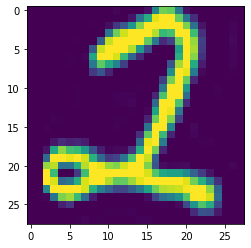

In [49]:
plt.imshow(image[:,:,0])

In [66]:
batch_size = 64
train_set = RMNIST(all_data, train=True, transform=transform)
test_set = RMNIST(all_data, train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                           shuffle=False)


In [67]:
# # functions to show an image


# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()


# # get some random training images
# dataiter = iter(train_loader)
# images, labels = dataiter.next()

# # show images
# imshow(torchvision.utils.make_grid(images))
# # print labels
# print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [68]:
from models.torch_fn.lenet import LeNet5
net = LeNet5(output_dim=10)


In [69]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [74]:
len(train_loader) * 64


1024

In [75]:
num_epochs = 2
print_every_steps = 8
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(train_loader):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if batch_idx % print_every_steps == print_every_steps - 1:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, batch_idx + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')


[1,     8] loss: 0.009
[1,    16] loss: 0.009
[2,     8] loss: 0.009
[2,    16] loss: 0.009
Finished Training


In [ ]:
# save trained model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)